In [1]:
%pwd

'/workspace'

In [2]:
%ls

models/           sample_submission.csv  test_processed.ftr  wandb/
models_aug/       submission.csv         train.parquet
predictions/      test.parquet           train_labels.csv
predictions_aug/  test_output.csv        training_data.ftr


In [1]:
import numpy as np 
import pandas as pd
import os, gc
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,LearningRateScheduler
from tab2img.converter import Tab2Img
from sklearn.preprocessing import StandardScaler
import warnings
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

2024-04-06 22:24:58.555836: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
os.environ["WANDB_PROJECT"]="cnn"
os.environ["WANDB_LOG_MODEL"] = "checkpoint"
model_path = "./models_d"
pred_path = "./predictions_d"

os.mkdir(model_path)
os.mkdir(pred_path)

In [4]:
wandb.login()

True

In [5]:
def amex_metric_mod(y_true, y_pred):
    
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:, 0] == 0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:, 0]) / np.sum(labels[:, 0])

    gini = [0, 0]
    for i in [1, 0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:, 0] == 0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] * weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1] / gini[0] + top_four)

def read_file(path = '', usecols = None):
    if usecols is not None: df = pd.read_parquet(path, columns=usecols)
    else: df = pd.read_parquet(path)

    df.S_2 = pd.to_datetime( df.S_2 )
    # Most numerical variables are 0 or greater and therefore the value -0.5 is distinct and will allow the model to recognize when and where the variable is NAN.
    df = df.fillna(-0.5) 
    print('shape of data:', df.shape)
    
    return df

def process_and_feature_engineer(df):
    all_cols = [c for c in list(df.columns) if c not in ['customer_ID','S_2']]
    cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
    num_features = [col for col in all_cols if col not in cat_features]
    print("Number of num_features: ", len(num_features))
    

    test_num_agg = df.groupby("customer_ID")[num_features].agg(['mean', 'min', 'max', 'last'])
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]

    test_cat_agg = df.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])
    test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]

    df = pd.concat([test_num_agg, test_cat_agg], axis=1)
    del test_num_agg, test_cat_agg
    print('shape after engineering', df.shape )
    
    return df

In [6]:
train = process_and_feature_engineer(read_file(path = 'train.parquet'))

shape of data: (5531451, 190)
Number of num_features:  177
shape after engineering (458913, 741)


In [7]:
train.isna().sum().sum()

0

In [8]:
train.head()

,P_2_mean,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_min,D_39_max,D_39_last,B_1_mean,B_1_min,...,D_63_nunique,D_64_count,D_64_last,D_64_nunique,D_66_count,D_66_last,D_66_nunique,D_68_count,D_68_last,D_68_nunique
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.933824,0.868580,0.960384,0.934745,0.230769,0,3,0,0.012007,0.001930,...,1,13,0,1,13,-1,1,13,6,1
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.899820,0.861109,0.929122,0.880519,7.153846,0,19,6,0.025654,0.006711,...,1,13,0,1,13,-1,1,13,6,1
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.878454,0.797670,0.904482,0.880875,0.000000,0,0,0,0.004386,0.001472,...,1,13,2,1,13,-1,1,13,6,1
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.598969,0.567442,0.623392,0.621776,1.538462,0,9,0,0.059876,0.005910,...,1,13,0,1,13,-1,1,13,3,3
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.891679,0.805045,0.940382,0.871900,0.000000,0,0,0,0.005941,0.000776,...,1,13,0,1,13,1,1,13,6,1


In [9]:
target = pd.read_csv("train_labels.csv").target

In [10]:
ss  = StandardScaler()
# Scale the data
train = ss.fit_transform(train)
# transform 1d tabular data to images
converter = Tab2Img()
images = converter.fit_transform(train, target.values)
images[0].shape

(28, 28)

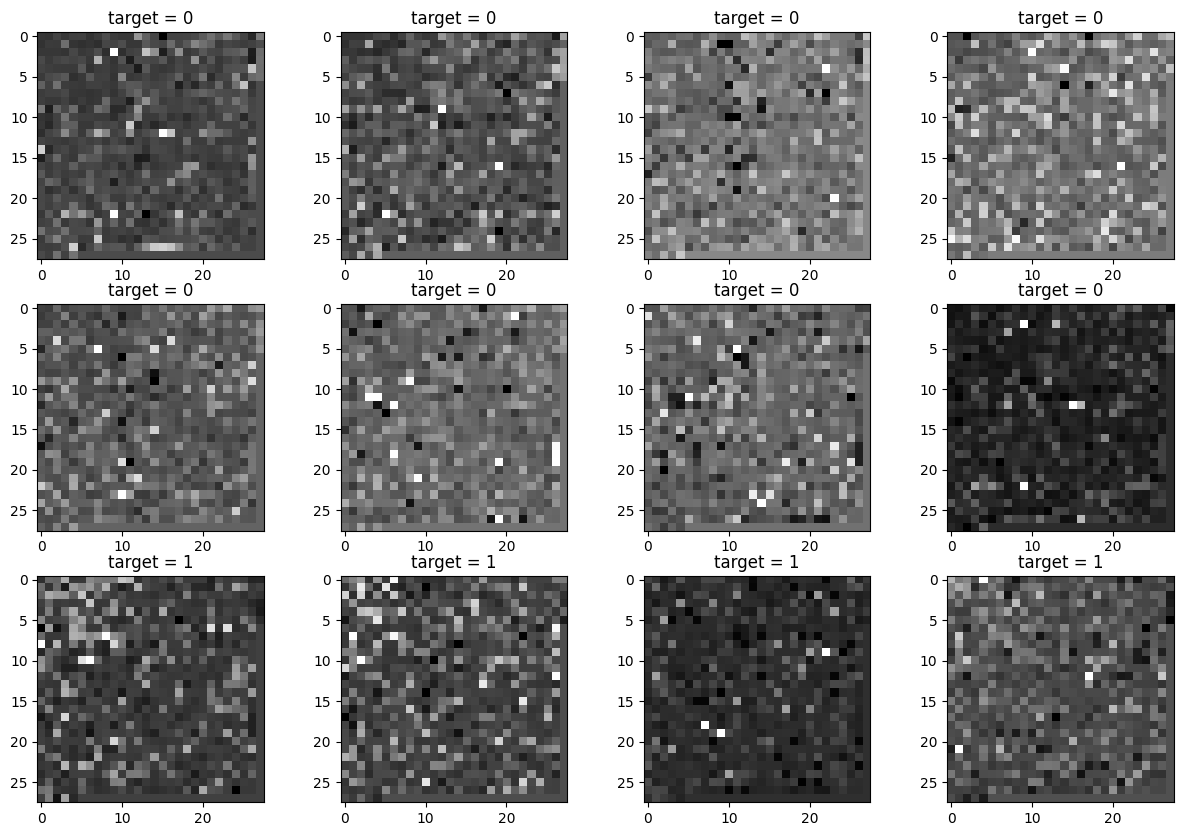

In [11]:
fig, ax = plt.subplots(3, 4, figsize=(15, 10))
ax = ax.flatten()
for i in range(12):
    ax[i].title.set_text(f"target = {target[i]}")
    ax[i].imshow(images[i], cmap = "gray")
plt.show()

# Add bottle neck layers in the U-Net.

In [13]:
def build_UNET_d():
    input_layer = keras.Input(shape=(28, 28, 1))
    x = layers.ZeroPadding2D(((4,0),(4,0)))(input_layer)

    # Contracting Path
    conv1 = layers.Conv2D(8, (3,3), activation="swish", padding="same")(x)
    conv1 = layers.Conv2D(8, (3,3), activation="swish", padding="same")(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2,2))(conv1)

    conv2 = layers.Conv2D(16, (3,3), activation="swish", padding="same")(pool1)
    conv2 = layers.Conv2D(16, (3,3), activation="swish", padding="same")(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = layers.Conv2D(32, (3,3), activation="swish", padding="same")(pool2)
    conv3 = layers.Conv2D(32, (3,3), activation="swish", padding="same")(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2,2))(conv3)

    conv4 = layers.Conv2D(64, (3,3), activation="swish", padding="same")(pool3)
    conv4 = layers.Conv2D(64, (3,3), activation="swish", padding="same")(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2,2))(conv4)
    
    conv5 = layers.Conv2D(128, (3,3), activation="swish", padding="same")(pool4)
    conv5 = layers.Conv2D(128, (3,3), activation="swish", padding="same")(conv5)
    pool5 = layers.MaxPooling2D(pool_size=(2,2))(conv5)

    # Bottleneck
    convm = layers.Conv2D(256, (3,3), activation="swish", padding="same")(pool5)
    convm = layers.Conv2D(256, (3,3), activation="swish", padding="same")(convm)
    convm = layers.Dropout(0.5)(convm)

    # Expansive Path
    up6 = layers.UpSampling2D(size=(2,2))(convm)
    cat6 = layers.Concatenate()([up6, conv5])
    conv6 = layers.Conv2D(128, (3,3), activation="swish",padding="same")(cat6)
    conv6 = layers.Conv2D(128, (3,3), activation="swish",padding="same")(conv6)
    conv6 = layers.BatchNormalization()(conv6)

    up7 = layers.UpSampling2D(size=(2,2))(conv6)
    cat7 = layers.Concatenate()([up7, conv4])
    conv7 = layers.Conv2D(64, (3,3), activation="swish", padding="same")(cat7)
    conv7 = layers.Conv2D(64, (3,3), activation="swish", padding="same")(conv7)
    conv7 = layers.BatchNormalization()(conv7)

    up8 = layers.UpSampling2D(size=(2,2))(conv7)
    cat8 = layers.Concatenate()([up8, conv3])
    conv8 = layers.Conv2D(32, (3,3), activation="swish", padding="same")(cat8)
    conv8 = layers.Conv2D(32, (3,3), activation="swish", padding="same")(conv8)
    conv8 = layers.BatchNormalization()(conv8)

    up9 = layers.UpSampling2D(size=(2,2))(conv8)
    cat9 = layers.Concatenate()([up9, conv2])
    conv9 = layers.Conv2D(16, (3,3), activation="swish", padding="same")(cat9)
    conv9 = layers.Conv2D(16, (3,3), activation="swish", padding="same")(conv9)
    conv9 = layers.BatchNormalization()(conv9)
    
    up10 = layers.UpSampling2D(size=(2,2))(conv9)
    cat10 = layers.Concatenate()([up10, conv1])
    conv10 = layers.Conv2D(8, (3,3), activation="swish", padding="same")(cat10)
    conv10 = layers.Conv2D(8, (3,3), activation="swish", padding="same")(conv10)
    conv10 = layers.BatchNormalization()(conv10)

    # Final layers
    x = layers.Conv2D(32, kernel_size=(3,3), strides=1, padding="same")(conv10)
    x = layers.Flatten()(x)
    x = layers.Dense(10)(x)
    output = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=input_layer, outputs=output)

    return model
build_UNET_d().summary()

2024-04-06 22:26:51.931827: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-06 22:26:51.952487: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-06 22:26:51.953031: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 32, 32, 1) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32, 8) │         80 │ zero_padding2d[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32, 8) │        584 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16, 8) │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │      1,168 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │      2,320 │ conv2d_2[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 16)  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 32)  │      4,640 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 32)  │      9,248 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 4, 4, 32)  │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 4, 4, 64)  │     18,496 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 4, 4, 64)  │     36,928 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 2, 2, 64)  │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 2, 2, 128) │     73,856 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 2, 2, 128) │    147,584 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 1, 1, 128) │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 1, 1, 256) │    295,168 │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 1, 1, 256) │    590,080 │ conv2d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1, 1, 256) │          0 │ conv2d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,297,341 (8.76 MB)

 Trainable params: 2,296,845 (8.76 MB)

 Non-trainable params: 496 (1.94 KB)

In [14]:
kfold = sklearn.model_selection.StratifiedKFold(n_splits=3)
batch_size = 1000

def run(images, target):
    fold_scores = []
    wandb.init(config={"bs": batch_size})


    for fold, (trn_idx, val_idx) in enumerate(kfold.split(images, target)):
        tf.keras.backend.clear_session()
        tf.random.set_seed(7453)
                
        X_train, y_train = images[trn_idx], target[trn_idx]
        X_val, y_val = images[val_idx], target[val_idx]
        print(f"#### fold: {fold +1} ####")

        initial_learning_rate = 0.01
        epochs = 75
        #epochs = 5
        lr = ReduceLROnPlateau(monitor="val_loss", 
                               factor=0.7, 
                               patience=3, 
                               verbose=0)

        model = build_UNET_d()
        
        model.compile(
            loss=tf.keras.losses.BinaryCrossentropy(),
            optimizer=tf.keras.optimizers.Nadam(
                learning_rate=initial_learning_rate, 
                clipvalue=0.5, 
                clipnorm=1.0
            ),
            metrics=["accuracy"],
        )

        mcp_save = tf.keras.callbacks.ModelCheckpoint(
            model_path+f"/best_model_{fold}.keras",
            save_best_only=True,
            monitor="val_loss",
            mode="auto",
        )

        ES = EarlyStopping(
            monitor="val_loss",
            min_delta=0,
            patience=10,
            verbose=0,
            mode="auto",
            baseline=None,
            restore_best_weights=True,
        )

        history = model.fit(
            X_train,
            y_train,
            epochs=epochs,
            verbose=1,
            batch_size=batch_size,
            validation_data=(
                    X_val, 
                    y_val, 
                    ),
            callbacks=[lr, mcp_save, ES, WandbMetricsLogger()]
        )

        y_pred = model.predict(X_val, 
                               batch_size=batch_size, 
                               verbose=0).ravel()

        score = amex_metric_mod(y_val, y_pred)
        print(f"Fold {fold + 1}: {score}")

        fold_scores.append(score)
        del (
            model,
            history,
            mcp_save,
        )

        del y_pred, score, X_train, y_train, X_val, y_val
        gc.collect()

    gc.collect()
    print(f"Overall score: {np.mean(fold_scores, axis=0)}")
    del fold_scores
    wandb.finish()

In [15]:
warnings.filterwarnings("ignore")
models = run(images, target)

#### fold: 1 ####
Epoch 1/75


I0000 00:00:1712442504.116193   46790 service.cc:145] XLA service 0x7f0ea80035b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712442504.116307   46790 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-04-06 22:28:24.458256: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-06 22:28:25.797467: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


  5/306 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.6707 - loss: 7.6407

I0000 00:00:1712442519.026309   46790 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7761 - loss: 10.7473

wandb: ERROR Unable to log learning rate.


306/306 ━━━━━━━━━━━━━━━━━━━━ 50s 84ms/step - accuracy: 0.7763 - loss: 10.7230 - val_accuracy: 0.8942 - val_loss: 0.2383 - learning_rate: 0.0100
Epoch 2/75
306/306 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.8957 - loss: 0.2341 - val_accuracy: 0.8945 - val_loss: 0.2367 - learning_rate: 0.0100
Epoch 3/75
306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8973 - loss: 0.2309 - val_accuracy: 0.8947 - val_loss: 0.2378 - learning_rate: 0.0100
Epoch 4/75
306/306 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.8952 - loss: 0.2373 - val_accuracy: 0.8943 - val_loss: 0.2389 - learning_rate: 0.0100
Epoch 5/75
306/306 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.8990 - loss: 0.2283 - val_accuracy: 0.8923 - val_loss: 0.2426 - learning_rate: 0.0100
Epoch 6/75
306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.9000 - loss: 0.2259 - val_accuracy: 0.8958 - val_loss: 0.2358 - learning_rate: 0.0070
Epoch 7/75
306/306 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.8994 - loss: 0.2265 - va

epoch/accuracy,▁▇▇▇▇▇▇██████▄▇▇▇▇▇▇▇▇██████▇▇▇▆▇▇▇▇▇███
epoch/epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▁▂▂▂▃▄▄▅▅▅▆▇▇██▁▂▂▃▃▄▄▅▅▆▆▇
epoch/learning_rate,████▅▅▅▅▃▃▂▂▁████▅▅▅▅▅▅▃▃▂▂▁███████▅▅▃▃▂
epoch/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▄▄▄▂▆▅▄▃▃▁▁▁▃▆▇▇▆▇▇▇▆▅▄▇▅▆▄▅▆▄▆▆██▆▄▂▄▄▅
epoch/val_loss,▆▅▅█▄▄▅▆▆███▇▅▂▂▄▂▂▂▃▄▅▃▃▃▄▃▄▅▃▃▁▁▂▄▆▅▅▅
epoch/accuracy,0.90363
epoch/epoch,16
epoch/learning_rate,0.00343
epoch/loss,0.21828
epoch/val_accuracy,0.89559


# 3x Image augmentation on the fly with random rotations and flips.	

In [17]:
# Triple the training dataset
images_con = np.concatenate((images, images, images), axis=0)
print(images_con.shape)
target_con = np.concatenate((target, target, target))
print(target_con.shape)

(1376739, 28, 28)
(1376739,)


In [18]:
def build_UNET_aug():
    input_layer = keras.Input(shape=(28, 28, 1))
    data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),])
    x = data_augmentation(input_layer)
    x = layers.ZeroPadding2D(((4,0),(4,0)))(x)

    conv1 = layers.Conv2D(8, (3,3), activation="swish", padding="same")(x)
    conv1 = layers.Conv2D(8, (3,3), activation="swish", padding="same")(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2,2))(conv1)

    conv2 = layers.Conv2D(16, (3,3), activation="swish", padding="same")(pool1)
    conv2 = layers.Conv2D(16, (3,3), activation="swish", padding="same")(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = layers.Conv2D(32, (3,3), activation="swish", padding="same")(pool2)
    conv3 = layers.Conv2D(32, (3,3), activation="swish", padding="same")(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2,2))(conv3)

    conv4 = layers.Conv2D(64, (3,3), activation="swish", padding="same")(pool3)
    conv4 = layers.Conv2D(64, (3,3), activation="swish", padding="same")(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2,2))(conv4)
    
    convm = layers.Conv2D(128, (3,3), activation="swish", padding="same")(pool4)
    convm = layers.Conv2D(128, (3,3), activation="swish", padding="same")(convm)

    ### UP

    up5 = layers.UpSampling2D(size=(2,2))(convm)
    cat5 = layers.Concatenate()([up5, conv4])
    conv5 = layers.Conv2D(64, (3,3), activation="swish",padding="same")(cat5)
    conv5 = layers.Conv2D(64, (3,3), activation="swish",padding="same")(conv5)
    conv5 = layers.BatchNormalization()(conv5)

    up6 = layers.UpSampling2D(size=(2,2))(conv5)
    cat6 = layers.Concatenate()([up6, conv3])
    conv6 = layers.Conv2D(32, (3,3), activation="swish", padding="same")(cat6)
    conv6 = layers.Conv2D(32, (3,3), activation="swish", padding="same")(conv6)
    conv6 = layers.BatchNormalization()(conv6)

    up7 = layers.UpSampling2D(size=(2,2))(conv6)
    cat7 = layers.Concatenate()([up7, conv2])
    conv7 = layers.Conv2D(16, (3,3), activation="swish", padding="same")(cat7)
    conv7 = layers.Conv2D(16, (3,3), activation="swish", padding="same")(conv7)
    x = layers.BatchNormalization()(conv7)
    
    up8 = layers.UpSampling2D(size=(2,2))(conv7)
    cat8 = layers.Concatenate()([up8, conv1])
    conv8 = layers.Conv2D(8, (3,3), activation="swish", padding="same")(cat8)
    conv8 = layers.Conv2D(8, (3,3), activation="swish", padding="same")(conv8)
    x = layers.BatchNormalization()(conv8)

    # predict
    x = layers.Conv2D(32, kernel_size=(3,3), strides=1, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(10)(x)
    output = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=input_layer, outputs=output)

    return model

In [ ]:
build_UNET_aug().summary()

In [24]:
kfold = sklearn.model_selection.StratifiedKFold(n_splits=3)
batch_size = 1000

def run(images, target):
    fold_scores = []
    wandb.init(config={"bs": batch_size})


    for fold, (trn_idx, val_idx) in enumerate(kfold.split(images, target)):
        tf.keras.backend.clear_session()
        tf.random.set_seed(7453)
                
        X_train, y_train = images[trn_idx], target[trn_idx]
        X_val, y_val = images[val_idx], target[val_idx]
        print(f"#### fold: {fold +1} ####")

        initial_learning_rate = 0.01
        epochs = 75
        #epochs = 5
        lr = ReduceLROnPlateau(monitor="val_loss", 
                               factor=0.7, 
                               patience=3, 
                               verbose=0)

        model = build_UNET_aug()
        
        model.compile(
            loss=tf.keras.losses.BinaryCrossentropy(),
            optimizer=tf.keras.optimizers.Nadam(
                learning_rate=initial_learning_rate, 
                clipvalue=0.5, 
                clipnorm=1.0
            ),
            metrics=["accuracy"],
        )

        mcp_save = tf.keras.callbacks.ModelCheckpoint(
            model_path+f"/best_model_{fold}.keras",
            save_best_only=True,
            monitor="val_loss",
            mode="auto",
        )

        ES = EarlyStopping(
            monitor="val_loss",
            min_delta=0,
            patience=10,
            verbose=0,
            mode="auto",
            baseline=None,
            restore_best_weights=True,
        )

        history = model.fit(
            X_train,
            y_train,
            epochs=epochs,
            verbose=1,
            batch_size=batch_size,
            validation_data=(
                    X_val, 
                    y_val, 
                    ),
            callbacks=[lr, mcp_save, ES, WandbMetricsLogger()]
        )

        y_pred = model.predict(X_val, 
                               batch_size=batch_size, 
                               verbose=0).ravel()

        score = amex_metric_mod(y_val, y_pred)
        print(f"Fold {fold + 1}: {score}")

        fold_scores.append(score)
        del (
            model,
            history,
            mcp_save,
        )

        del y_pred, score, X_train, y_train, X_val, y_val
        gc.collect()
        
        # for testing
        # if fold == 0: break

    gc.collect()
    print(f"Overall score: {np.mean(fold_scores, axis=0)}")
    del fold_scores
    wandb.finish()

In [25]:
warnings.filterwarnings("ignore")
models = run(images_con, target_con)

#### fold: 1 ####
Epoch 1/75


2024-04-06 20:48:01.074090: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


918/918 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7392 - loss: 3.9594

wandb: ERROR Unable to log learning rate.


918/918 ━━━━━━━━━━━━━━━━━━━━ 68s 61ms/step - accuracy: 0.7392 - loss: 3.9563 - val_accuracy: 0.2589 - val_loss: 1.3430 - learning_rate: 0.0100
Epoch 2/75
918/918 ━━━━━━━━━━━━━━━━━━━━ 50s 55ms/step - accuracy: 0.8469 - loss: 0.3361 - val_accuracy: 0.2589 - val_loss: 1.7188 - learning_rate: 0.0100
Epoch 3/75
918/918 ━━━━━━━━━━━━━━━━━━━━ 50s 54ms/step - accuracy: 0.8616 - loss: 0.3059 - val_accuracy: 0.8186 - val_loss: 0.4330 - learning_rate: 0.0100
Epoch 4/75
918/918 ━━━━━━━━━━━━━━━━━━━━ 50s 55ms/step - accuracy: 0.8680 - loss: 0.2925 - val_accuracy: 0.4822 - val_loss: 0.8391 - learning_rate: 0.0100
Epoch 5/75
918/918 ━━━━━━━━━━━━━━━━━━━━ 51s 55ms/step - accuracy: 0.8216 - loss: 0.6902 - val_accuracy: 0.7415 - val_loss: 0.5109 - learning_rate: 0.0100
Epoch 6/75
918/918 ━━━━━━━━━━━━━━━━━━━━ 50s 54ms/step - accuracy: 0.8206 - loss: 0.3866 - val_accuracy: 0.7464 - val_loss: 0.4738 - learning_rate: 0.0100
Epoch 7/75
918/918 ━━━━━━━━━━━━━━━━━━━━ 51s 55ms/step - accuracy: 0.8492 - loss: 0.3315

epoch/accuracy,▄▇▄▆▇▇▇▇██████████████████▅▇█▆▆▇▇▁▁▁▁▁▁▁
epoch/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██▁▁▂▂▂▂▃▁▁▂▂▂▂▃
epoch/learning_rate,███▆▆▆▆▆▆▆▆▆▆▄▃▃▂▂▂▂▂▁▁▁▁▁████▆▄▃██▆▆▄▃▂
epoch/loss,█▁▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▄▂▁▁▃▃▃▃▃▃▃
epoch/val_accuracy,▁▇▆██████████████████████████▆███▆▆▆▆▆▆▆
epoch/val_loss,▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,0.74107
epoch/epoch,14
epoch/learning_rate,0.0024
epoch/loss,0.57195
epoch/val_accuracy,0.74107


In [ ]:
wandb.finish()

# Feature Engineering, expand features from 190 to 741.

In [46]:
def build_UNET():
    input_layer = keras.Input(shape=(28, 28, 1))
    x = layers.ZeroPadding2D(((4,0),(4,0)))(input_layer)

    conv1 = layers.Conv2D(8, (3,3), activation="swish", padding="same")(x)
    conv1 = layers.Conv2D(8, (3,3), activation="swish", padding="same")(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2,2))(conv1)

    conv2 = layers.Conv2D(16, (3,3), activation="swish", padding="same")(pool1)
    conv2 = layers.Conv2D(16, (3,3), activation="swish", padding="same")(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = layers.Conv2D(32, (3,3), activation="swish", padding="same")(pool2)
    conv3 = layers.Conv2D(32, (3,3), activation="swish", padding="same")(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2,2))(conv3)

    conv4 = layers.Conv2D(64, (3,3), activation="swish", padding="same")(pool3)
    conv4 = layers.Conv2D(64, (3,3), activation="swish", padding="same")(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2,2))(conv4)
    
    convm = layers.Conv2D(128, (3,3), activation="swish", padding="same")(pool4)
    convm = layers.Conv2D(128, (3,3), activation="swish", padding="same")(convm)


    up5 = layers.UpSampling2D(size=(2,2))(convm)
    cat5 = layers.Concatenate()([up5, conv4])
    conv5 = layers.Conv2D(64, (3,3), activation="swish",padding="same")(cat5)
    conv5 = layers.Conv2D(64, (3,3), activation="swish",padding="same")(conv5)
    conv5 = layers.BatchNormalization()(conv5)

    up6 = layers.UpSampling2D(size=(2,2))(conv5)
    cat6 = layers.Concatenate()([up6, conv3])
    conv6 = layers.Conv2D(32, (3,3), activation="swish", padding="same")(cat6)
    conv6 = layers.Conv2D(32, (3,3), activation="swish", padding="same")(conv6)
    conv6 = layers.BatchNormalization()(conv6)

    up7 = layers.UpSampling2D(size=(2,2))(conv6)
    cat7 = layers.Concatenate()([up7, conv2])
    conv7 = layers.Conv2D(16, (3,3), activation="swish", padding="same")(cat7)
    conv7 = layers.Conv2D(16, (3,3), activation="swish", padding="same")(conv7)
    x = layers.BatchNormalization()(conv7)
    
    up8 = layers.UpSampling2D(size=(2,2))(conv7)
    cat8 = layers.Concatenate()([up8, conv1])
    conv8 = layers.Conv2D(8, (3,3), activation="swish", padding="same")(cat8)
    conv8 = layers.Conv2D(8, (3,3), activation="swish", padding="same")(conv8)
    x = layers.BatchNormalization()(conv8)

    x = layers.Conv2D(32, kernel_size=(3,3), strides=1, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(10)(x)
    output = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=input_layer, outputs=output)

    return model

In [47]:
build_UNET().summary()

2024-04-06 18:05:29.466193: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-06 18:05:29.491115: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-06 18:05:29.492073: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 32, 32, 1) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32, 8) │         80 │ zero_padding2d[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32, 8) │        584 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16, 8) │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │      1,168 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │      2,320 │ conv2d_2[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 16)  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 32)  │      4,640 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 32)  │      9,248 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 4, 4, 32)  │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 4, 4, 64)  │     18,496 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 4, 4, 64)  │     36,928 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 2, 2, 64)  │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 2, 2, 128) │     73,856 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 2, 2, 128) │    147,584 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 4, 4, 128) │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4, 4, 192) │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │                   │            │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 4, 4, 64)  │    110,656 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 4, 4, 64)  │     36,928 │ conv2d_10[0][0] 

 Total params: 821,437 (3.13 MB)

 Trainable params: 821,229 (3.13 MB)

 Non-trainable params: 208 (832.00 B)

In [49]:
kfold = sklearn.model_selection.StratifiedKFold(n_splits=3)

batch_size = 1000

def run(images, target):
    fold_scores = []

    for fold, (trn_idx, val_idx) in enumerate(kfold.split(images, target)):
        tf.keras.backend.clear_session()
        
        
        # set random seed for fold
        tf.random.set_seed(7453)
        
        
        X_train, y_train = images[trn_idx], target[trn_idx]
        X_val, y_val = images[val_idx], target[val_idx]
        print(f"#### fold: {fold +1} ####")

        initial_learning_rate = 0.01
        epochs = 75
        #epochs = 5
        lr = ReduceLROnPlateau(monitor="val_loss", 
                               factor=0.7, 
                               patience=3, 
                               verbose=0)

        model = build_UNET()
        
        model.compile(
            loss=tf.keras.losses.BinaryCrossentropy(),
            optimizer=tf.keras.optimizers.Nadam(
                learning_rate=initial_learning_rate, 
                clipvalue=0.5, 
                clipnorm=1.0
            ),
            metrics=["accuracy"],
        )

        mcp_save = tf.keras.callbacks.ModelCheckpoint(
            f"./models/best_model_{fold}.keras",
            save_best_only=True,
            monitor="val_loss",
            mode="auto",
        )

        ES = EarlyStopping(
            monitor="val_loss",
            min_delta=0,
            patience=10,
            verbose=0,
            mode="auto",
            baseline=None,
            restore_best_weights=True,
        )

        history = model.fit(
            X_train,
            y_train,
            epochs=epochs,
            verbose=1,
            batch_size=batch_size,
            validation_data=(
                    X_val, 
                    y_val, 
                    ),
            callbacks=[lr, mcp_save, ES],
        )

        y_pred = model.predict(X_val, 
                               batch_size=batch_size, 
                               verbose=0).ravel()

        score = amex_metric_mod(y_val, y_pred)
        print(f"Fold {fold + 1}: {score}")

        fold_scores.append(score)
        del (
            model,
            history,
            mcp_save,
        )

        del y_pred, score, X_train, y_train, X_val, y_val
        gc.collect()

    gc.collect()
    print(f"Overall score: {np.mean(fold_scores, axis=0)}")
    del fold_scores

In [51]:
# TRAINING
warnings.filterwarnings("ignore")
models = run(images, target)

#### fold: 1 ####
Epoch 1/75


I0000 00:00:1712426895.374587    2165 service.cc:145] XLA service 0x7f3c9c009fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712426895.375191    2165 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-04-06 18:08:15.654175: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-06 18:08:16.733907: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


  7/306 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.5014 - loss: 28.6043

I0000 00:00:1712426906.860576    2165 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


306/306 ━━━━━━━━━━━━━━━━━━━━ 40s 69ms/step - accuracy: 0.7382 - loss: 14.0524 - val_accuracy: 0.7884 - val_loss: 0.3998 - learning_rate: 0.0100
Epoch 2/75
306/306 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.8847 - loss: 0.2579 - val_accuracy: 0.8880 - val_loss: 0.2604 - learning_rate: 0.0100
Epoch 3/75
306/306 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.8889 - loss: 0.2483 - val_accuracy: 0.8893 - val_loss: 0.2466 - learning_rate: 0.0100
Epoch 4/75
306/306 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.8913 - loss: 0.2427 - val_accuracy: 0.8914 - val_loss: 0.2437 - learning_rate: 0.0100
Epoch 5/75
306/306 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.8926 - loss: 0.2403 - val_accuracy: 0.8925 - val_loss: 0.2414 - learning_rate: 0.0100
Epoch 6/75
306/306 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.8934 - loss: 0.2385 - val_accuracy: 0.8935 - val_loss: 0.2397 - learning_rate: 0.0100
Epoch 7/75
306/306 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.8933 - loss: 0.2385 - va

# Inference

In [20]:
del images
gc.collect()

1456

In [17]:
def read_file(path = '', usecols = None):
    if usecols is not None: df = pd.read_parquet(path, columns=usecols)
    else: df = pd.read_parquet(path)
    df.S_2 = pd.to_datetime( df.S_2 )
    df = df.fillna(-0.5) 
    print('shape of data:', df.shape)
    
    return df

TEST_PATH = 'test.parquet'
test = read_file(path = TEST_PATH)
test = process_and_feature_engineer(test)

shape of data: (11363762, 190)
Number of num_features:  177
shape after engineering (924621, 741)


In [18]:
test.isna().sum().sum()

0

In [21]:
test = ss.transform(test)
test = converter.transform(test)

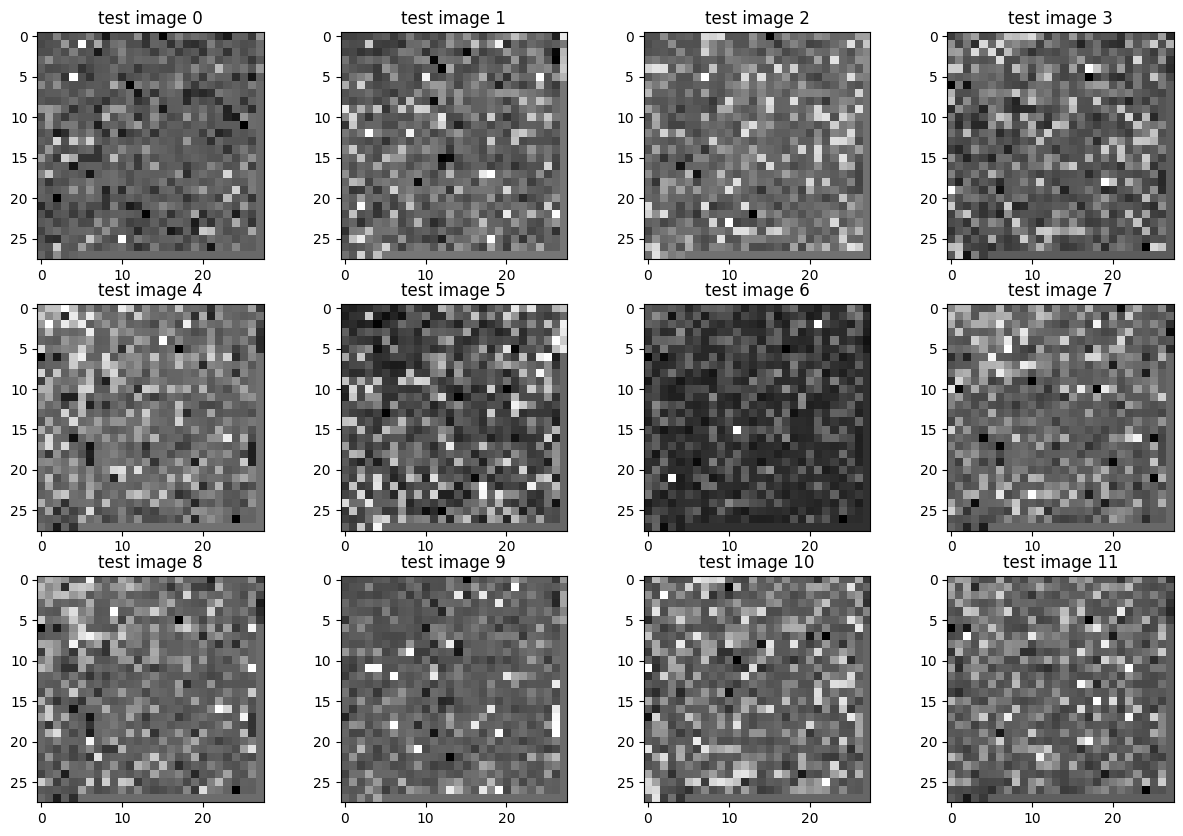

In [22]:
fig, ax = plt.subplots(3, 4, figsize=(15, 10))
ax = ax.flatten()
for i in range(12):
    ax[i].title.set_text(f"test image {i}")
    ax[i].imshow(test[i], cmap = "gray")

plt.show()

In [23]:
model_path = "./models_d"
pred_path = "./predictions_d"
for num, model in enumerate(os.listdir(model_path+"/")):
    # loop to make predictions in chunks
    preds = []
    model = keras.models.load_model(model_path+"/" + model)
    chunk_size = int(test.shape[0] / 10)
    for start in range(0, test.shape[0], chunk_size):
        test_subset = test[start : start + chunk_size]
        preds.extend(model.predict(test_subset, batch_size=batch_size, verbose=0).flatten())

    # loop to save predictions
    sub = pd.read_csv("sample_submission.csv")
    del sub["prediction"]
    sub["prediction"] = preds
    sub.to_csv(pred_path+f"/{num}_preds.csv")
    del sub, model
    gc.collect()
    
sub = pd.read_csv("sample_submission.csv")
del sub["prediction"]
gc.collect()

# average predictions for final score
for num, data in enumerate(os.listdir(pred_path+"/")):

    p1 = pd.read_csv(pred_path+f"/{data}")
    del p1["Unnamed: 0"]
    sub[f"{num}_prediction"] = p1["prediction"]

    del p1
    gc.collect()

sub.to_csv("test_output.csv")
sub["prediction"] = sub.iloc[:, 1:].mean(axis=1)
sub = sub[["customer_ID", "prediction"]]
sub.to_csv("submission.csv", index=False)

In [24]:
sub.head()

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.064805
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.002361
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.055087
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.294898
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.811430


In [33]:
model_path = "./models_aug"
pred_path = "./predictions_aug"
# Make predictions
for num, model in enumerate(os.listdir(model_path+"/")):
    # loop to make predictions in chunks
    preds = []
    model = keras.models.load_model(model_path+"/" + model)
    chunk_size = int(test.shape[0] / 10)
    for start in range(0, test.shape[0], chunk_size):
        test_subset = test[start : start + chunk_size]
        preds.extend(model.predict(test_subset, batch_size=batch_size, verbose=0).flatten())

    # loop to save predictions
    sub = pd.read_csv("sample_submission.csv")
    del sub["prediction"]
    sub["prediction"] = preds
    sub.to_csv(pred_path+f"/{num}_preds.csv")
    del sub, model
    gc.collect()
    
sub = pd.read_csv("sample_submission.csv")
del sub["prediction"]
gc.collect()

# average predictions for final score
for num, data in enumerate(os.listdir(pred_path+"/")):

    p1 = pd.read_csv(pred_path+f"/{data}")
    del p1["Unnamed: 0"]
    sub[f"{num}_prediction"] = p1["prediction"]

    del p1
    gc.collect()

sub.to_csv("test_output.csv")
sub["prediction"] = sub.iloc[:, 1:].mean(axis=1)
sub = sub[["customer_ID", "prediction"]]
sub.to_csv("submission.csv", index=False)

In [34]:
sub.head()

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.187481
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.114655
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.133678
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.401972
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.570983


In [58]:
# Make predictions
for num, model in enumerate(os.listdir("./models/")):
    # loop to make predictions in chunks
    preds = []
    model = keras.models.load_model("./models/" + model)
    chunk_size = int(test.shape[0] / 10)
    for start in range(0, test.shape[0], chunk_size):
        test_subset = test[start : start + chunk_size]
        preds.extend(model.predict(test_subset, batch_size=batch_size, verbose=0).flatten())

    # loop to save predictions
    sub = pd.read_csv("sample_submission.csv")
    del sub["prediction"]
    sub["prediction"] = preds
    sub.to_csv(f"./predictions/{num}_preds.csv")
    del sub, model
    gc.collect()

In [59]:
sub = pd.read_csv("sample_submission.csv")
del sub["prediction"]
gc.collect()

0

In [60]:
# average predictions for final score
for num, data in enumerate(os.listdir("./predictions/")):

    p1 = pd.read_csv(f"./predictions/{data}")
    del p1["Unnamed: 0"]
    sub[f"{num}_prediction"] = p1["prediction"]

    del p1
    gc.collect()

sub.to_csv("test_output.csv")
sub["prediction"] = sub.iloc[:, 1:].mean(axis=1)
sub = sub[["customer_ID", "prediction"]]
sub.to_csv("submission.csv", index=False)

In [62]:
sub.head()

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.096609
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.003035
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.068820
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.324311
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.865393
